# Brain Tumor Classification

## Abstract of Work
This project works on Brain Tumor MRI image classification dataset, and is divided into 2 independent tasks, which is **image compression** task and **tumor type classification** task. For the first one, it can be viewed as an unsupervised learning task, and is solved by **Principal Component Analysis (PCA)** and **Convolutional Autoencoder** method. 

For the second one, it is treated as a supervised classification task, and is tackled with **Support Vector Classifier (SVC)**, **Logisitic Regression**, **Convolutional Neural Network (CNN)**, and **Transfer Learning method** featuring MobileNet V2 as a base model. In addition, the project adopts **cross validation procedure** in the model selection period for classical machine learning methods. And a brief analysis with visualization of dataset is placed ahead of application of methods.

In terms of the results, the projects finds convolutional autoencoder have the best reconstruction performance, with MSE loss below 0.01 in both train and test set. And Transfer Learning adapted from MobileNet V2 have the best classification performance, with F1-score over 0.90 on train set and validation set, over 0.80 on given real-world test set. Furthermore, some interesting findings of results for misclassified samples is given and explained for several methods.

**Note** This project puts some utility functions into utils.py, please make sure to run in the same directory. 

## Introduction to Dataset
A Brain tumor is considered as one of the most aggressive diseases, among children and adults. The 5-year survival rate for people with a cancerous brain or CNS tumor is approximately 34 percent for men and 36 percent for women. And the best technique to detect brain tumors is Magnetic Resonance Imaging (MRI). The dataset is contributed by Navoneel Chakrabarty and Swati Kanchan.

This dataset provides a huge amount of image data generated through the scans. These images are typically examined by the radiologist. However, a manual examination can be error-prone due to the complexities. Hence, proposing a system performing detection and classification is the main goal of this dataset.

## Data Visualization
### Data Collection

In [38]:
from utils import import_images
img_size = 128
img_shape = (img_size, img_size)
labels = ["glioma_tumor", "meningioma_tumor", "pituitary_tumor", "no_tumor"]
(x_train, x_validate, x_test, 
 y_train, y_validate, y_test) = import_images(labels=labels, img_size=img_size, categorical=False)

100%|██████████| 105/105 [00:00<00:00, 681.06it/s]


### Brain Tumor MRI Images

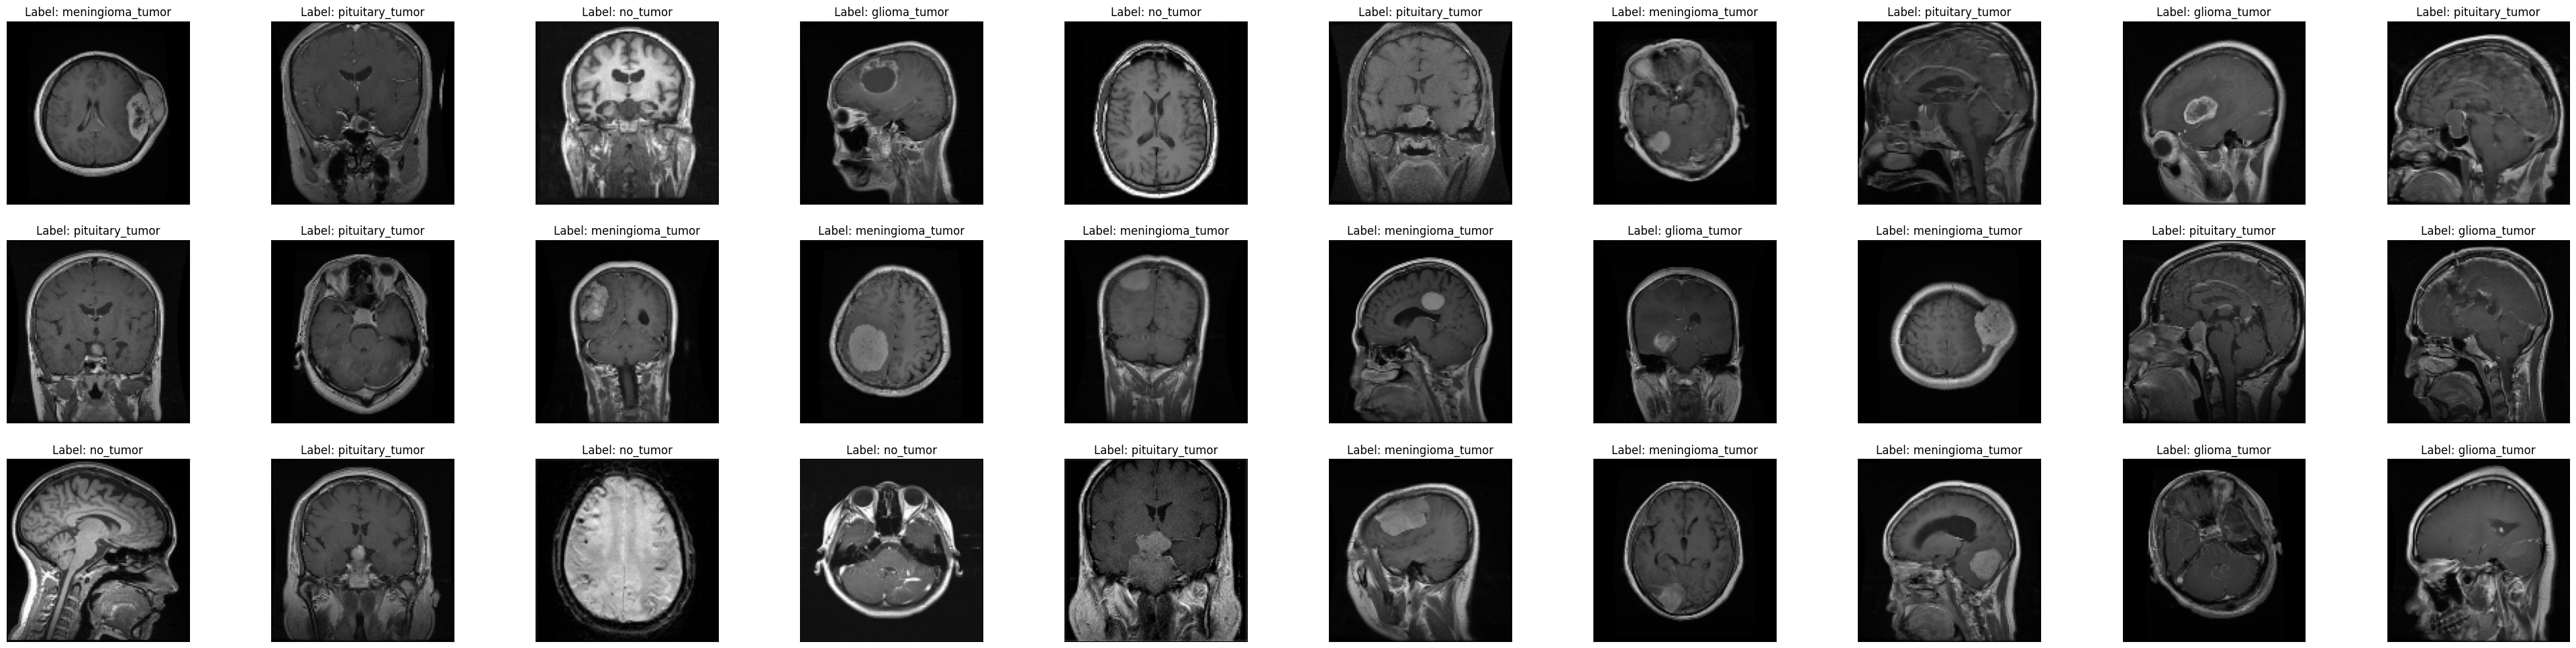

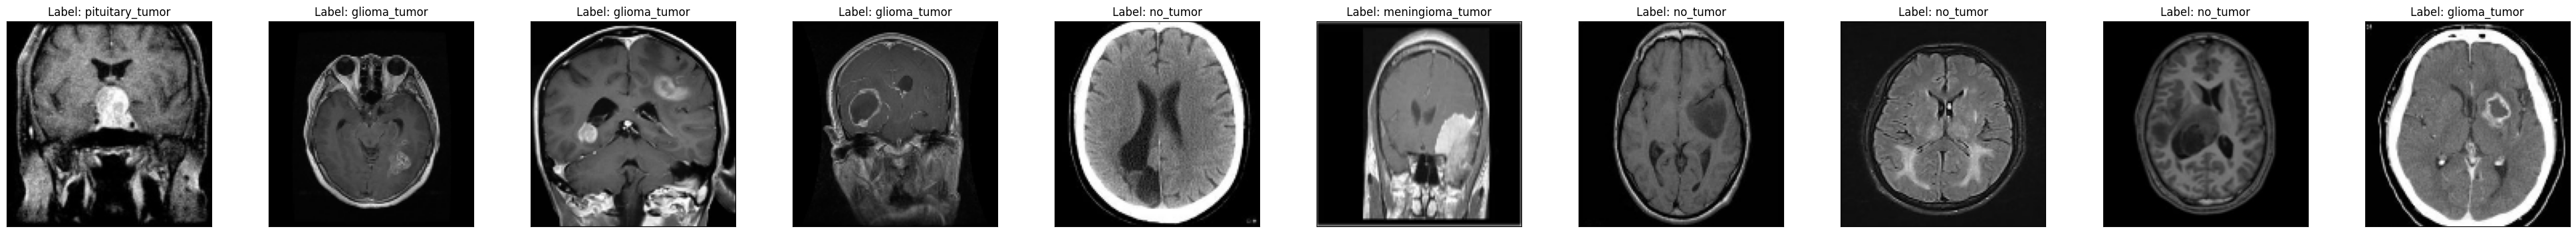

In [39]:
from utils import plot_images
plot_images(x_train, y_train, nrow=3, ncol=10, randomize=False)
plot_images(x_test, y_test, nrow=1, ncol=10, randomize=False)

From MRI images above, we can see that the images includes coronal section, median sagittal section, and tranverse section. Different types of tumors are exposed in various sectional images. This is helpful since it provides us with more features of a tumor in multiple directions.

We can easily identify some basic patterns of brain tumor. 
- **Glioma tumors** originate from glial cells or spine, so they have small sizes in MRI images and appear more randomly in the brain. 
- **Meningioma tumors** arise from the meninges, located typically on the surface of the brain, and we can see from images it located more close to the edge. 
- **Pituitary tumors** arise from and locate in the pituitary gland, and we can always tell them from same place in the MRI images.

For the comparison between given **Training and Testing** set, there are also things to notice. In training samples, images are more organized, with different section images of some same patient. And in test samples, sections are more discrete or unique, with images from unseen patients with fewer sample sections. What's more, those testing images have more variant brightness, contrast, shape and noise, which makes it more like real-world data and thus more difficult to predict.

### Distribution of Labels

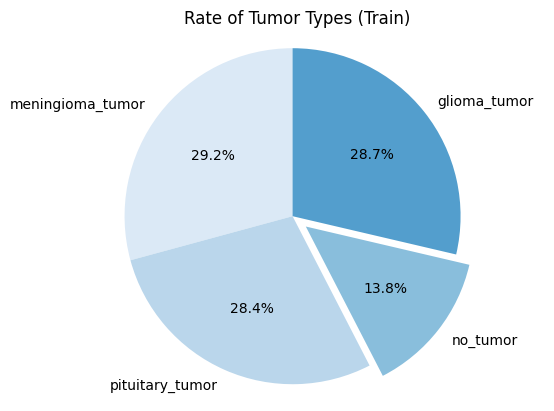

In [40]:
from utils import plot_labels
plot_labels(y_train, "Train")

By the pie plot, we can see that it is generally a balanced set for tumor classification except for no tumors type. And we still need to use F1 score in addition to accuracy to measure our models.

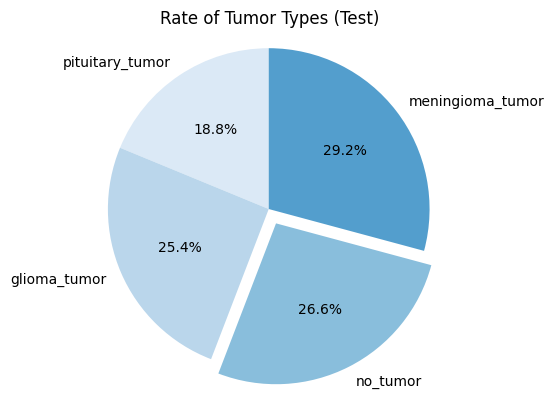

In [41]:
plot_labels(y_test, "Test")

Distribution for test set is different from train set, but without much variation. It is fine for our prediction task.

## Unsupervised Learning Task
Our final task is the classification. However, if we want to test basic classical machine learning methods, the result sometimes suffers a lot by the problem of dimensionality. This inspires us to carry out the dimensional reduction. For image, dimensional reduction task is also more often referred as image compression task, which finds its application in various aspects of computer vision.

For this task, 2 compression methods are implemented.
- Principal Components Analysis
- Autoencoder based on convolutinal layers

### Principal Component Analysis
Principal Component Analysis as is referred in class, is an efficient way to capture the most variance of dataset, while minimizing the projection error. 

#### Data Preprocessing
First we import training images and scale pixel value of our images between 0 and 1.

In [42]:
(x_train, _, x_test, _, _, _) = import_images(labels=labels, 
                                              img_size=img_size, 
                                              validate_size=1,
                                              mono=True)

100%|██████████| 105/105 [00:00<00:00, 1520.72it/s]


In [43]:
x_train = x_train / 255.0
x_test = x_test / 255.0

#### Model Fitting

In [44]:
from sklearn.decomposition import PCA
pca = PCA(0.8)
pca.fit(x_train.reshape(-1, img_size*img_size))
print(f"Numbers of principal components: {pca.n_components_}")

Numbers of principal components: 199


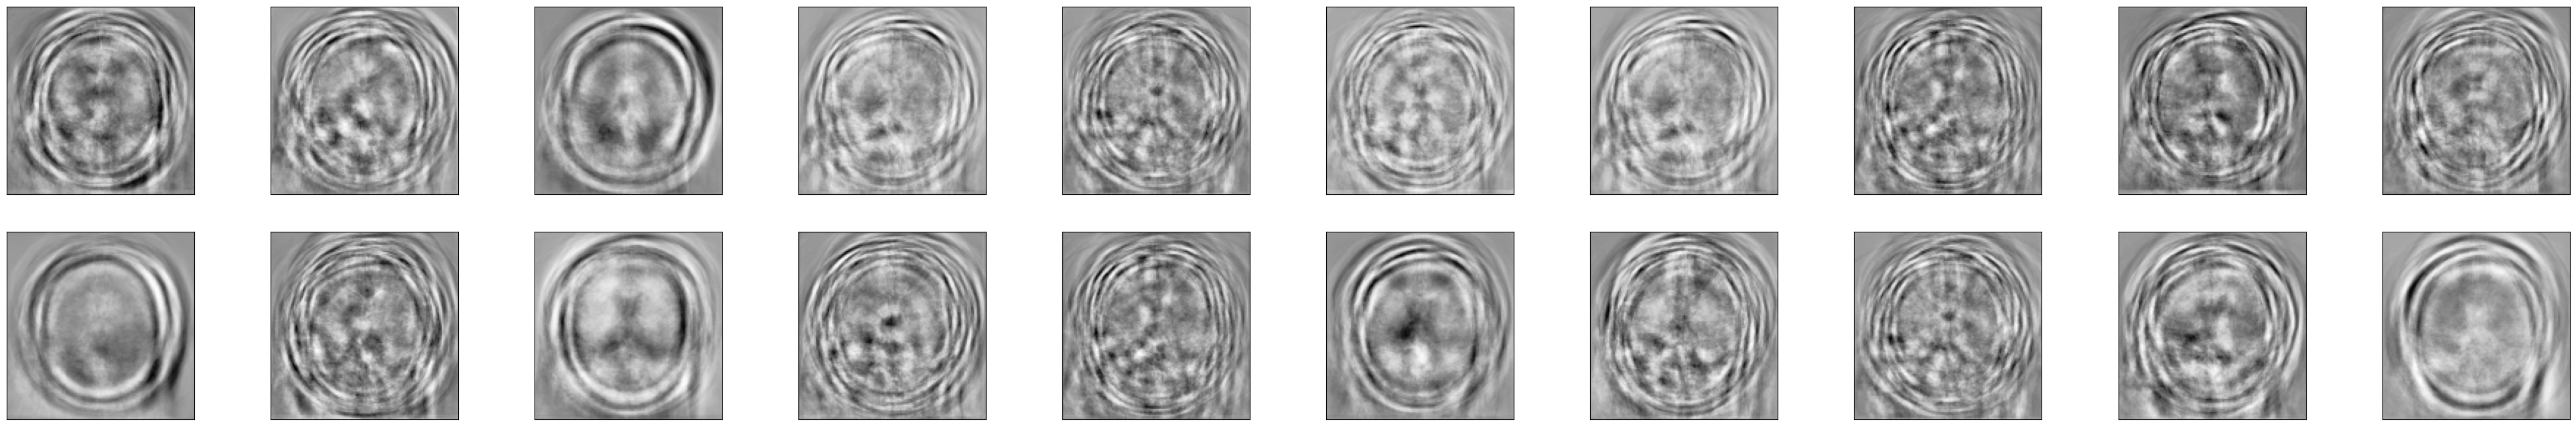

In [45]:
plot_images(pca.components_.reshape(-1, 128, 128), ncol=10, nrow=2)

We can see from PCA components plots that PCA methods do characterize some texture and position features of our images

#### Evaluation

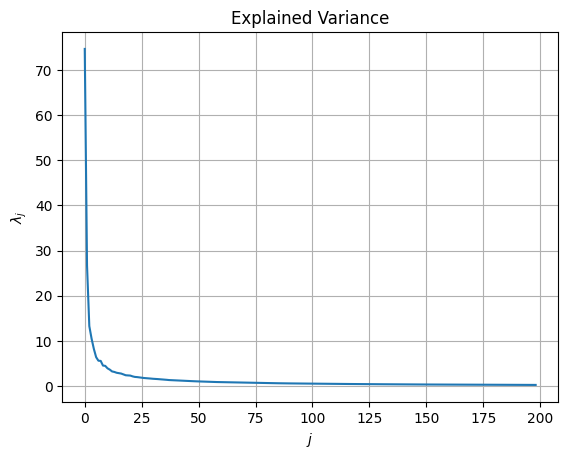

In [46]:
from matplotlib import pyplot as plt
plt.plot(pca.explained_variance_)
plt.xlabel(r'$j$')
plt.ylabel(r'$\lambda_j$');
plt.title('Explained Variance');
plt.grid(True)

From the plot we can see that first 199 components explains 80% percent of variance. Next we can do the transformation and reconstruction on our test images.

(394, 128, 128)

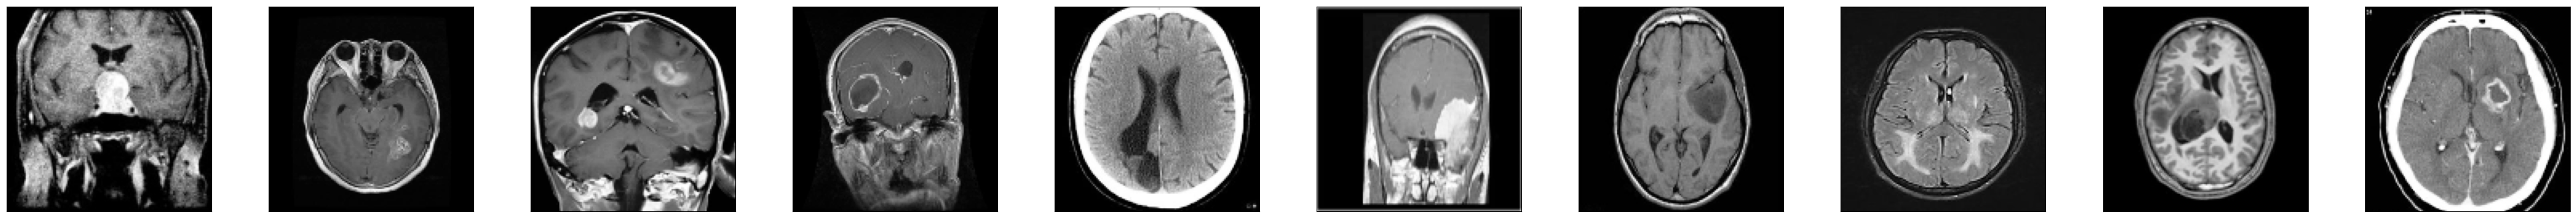

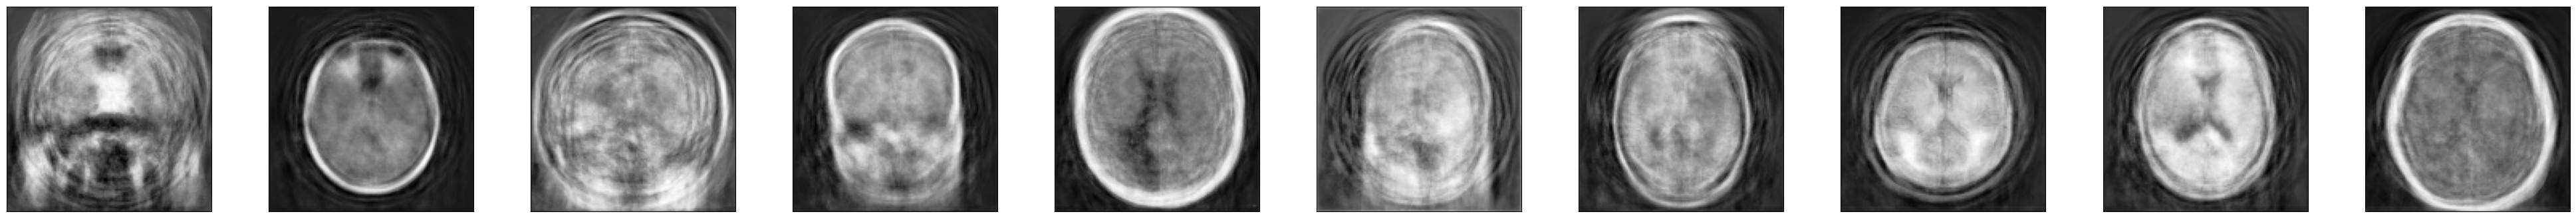

In [47]:
scores = pca.transform(x_test.reshape(-1, img_size*img_size))
x_recon = pca.inverse_transform(scores)
plot_images(x_test, randomize=False, nrow=1, ncol=10)
plot_images(x_recon, randomize=False, nrow=1, ncol=10)
x_test.shape

We can see from reconstructed images that PCA do efficient compression tasks, but many details of tumor will be sacrificed.

### Autoencoder

#### Data Import and Preprocessing
We use similar way to preprocess data, and this time we use max-scaling to match the input of our trained model.

In [48]:
(x_train, x_validate, x_test, 
 y_train, y_validate, y_test) = import_images(labels=["no_tumor", "pituitary_tumor", "glioma_tumor", "meningioma_tumor"], 
                                              img_size=img_size, 
                                              validate_size=1, 
                                              categorical=False)
img_shape = (img_size, img_size) + (3,)

100%|██████████| 115/115 [00:00<00:00, 677.79it/s]


In [49]:
import numpy as np
max_values = x_train.max(axis=(1,2,3))
x_train = x_train / max_values[:, np.newaxis, np.newaxis, np.newaxis]
max_values = x_test.max(axis=(1,2,3))
x_test = x_test / max_values[:, np.newaxis, np.newaxis, np.newaxis]

Trained models are loaded for efficiency

In [50]:
from keras.models import load_model
import os
autoencoder_model = load_model(os.path.join("saved_model", "autoencoder.keras"))
encoder_model = load_model(os.path.join(".", "saved_model", "encoder.keras"))

In [51]:
autoencoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856 

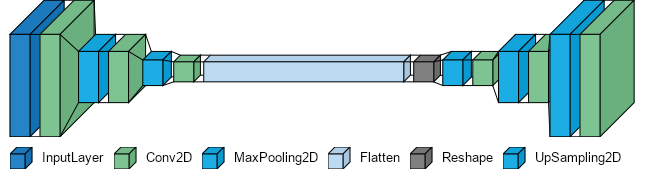

In [52]:
from utils import plot_nn_structure
plot_nn_structure(autoencoder_model)

By the summary output and visualized structure, the encoder model use 3 convolutional layers for dimensional reduction, and use 3 upsampling layers to reverse this process. 

#### Evaluation and Encode-decode Result

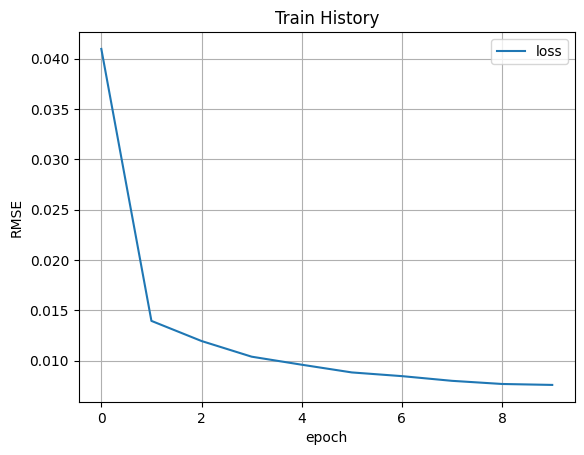

In [53]:
import json
import pandas as pd
with open(os.path.join("saved_model", "autoencoder_training_history.json"), "r") as json_file:
    history = json.load(json_file)
fig, ax = plt.subplots()
history_df = pd.DataFrame(history)
history_df.plot(x="epoch", y=["loss"], ax=ax);
ax.grid(True);
ax.set_ylabel('RMSE');
ax.set_title("Train History");

The plot shows the training results by the autoencoder, we can see RMSE loss value below 0.01 on the final epoch. 

In [54]:
autoencoder_model.evaluate(x_test, x_test)

13/13 [==============================] - 2s 176ms/step - loss: 0.0099


0.009913969784975052

The MSE losses for test set is also under 0.01, we can say the method generalizes well in this problem.

#### Encoding and Decoding
Then we can use trained convolutional autoencoder model to encode our image to reduce the dimension.

13/13 [==============================] - 1s 61ms/step


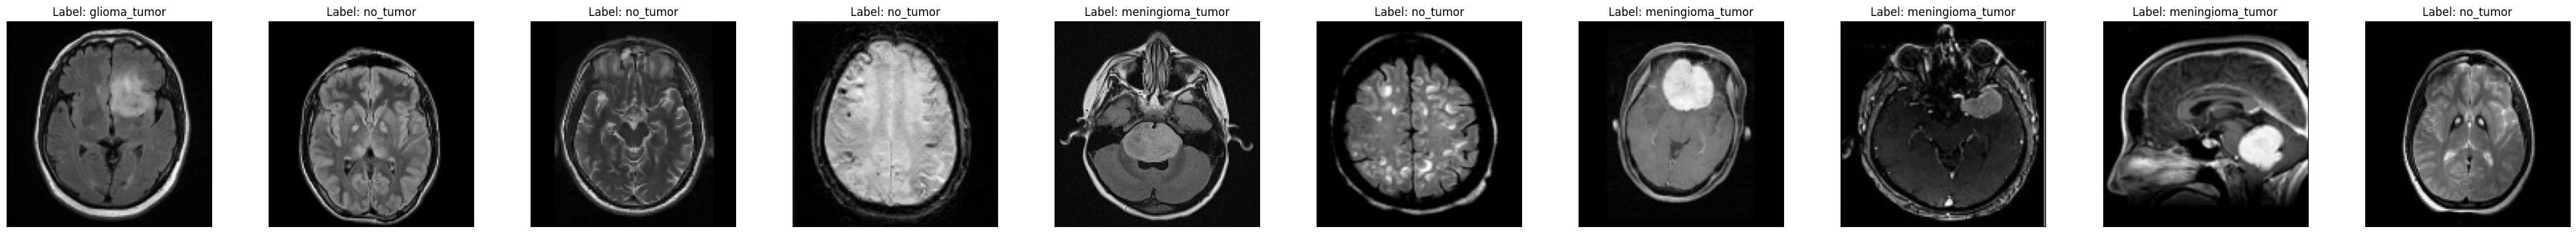

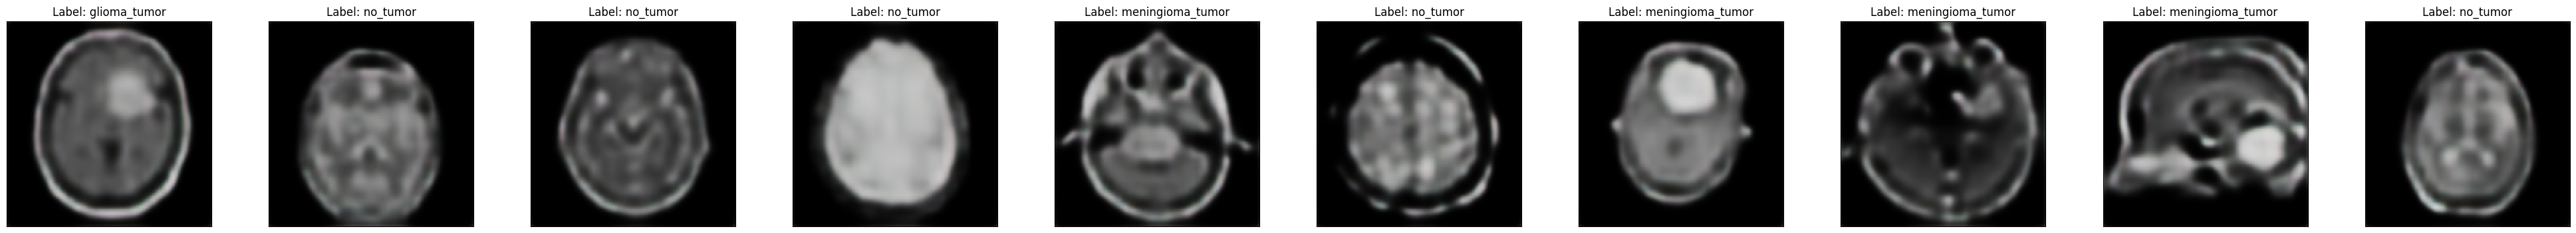

In [55]:
x_test_reconstructed = autoencoder_model.predict(x=x_test)
x_test_coded = encoder_model.predict(x=x_test).reshape((-1, 256, 128))
plot_images(x_test, y_test, nrow=1, ncol=10, randomize=False)
plot_images(x_test_reconstructed, y_test, nrow=1, ncol=10, randomize=False)

From coded and reconstructed images, we can see that insignificant details are blurred and features of tumors itself still stands out. And this outcome is based on only half the original dimensions of data.

To summarize our image compression task, PCA is obviously more efficient, taking less time and reduces more dimensions, but it comes with low fidelity. Autoencoder preserves more information, but it has computational costs and hard to evaluate variance explain ability.

Now we can preceed for the main classification task.

## Supervised Learning Task
For the 4-class classification, we use 2 classical machine-learning methods and neural network structure in this problem.
- SVM and Logistic Regression
- Convolutional Neural Network
- Transfer Learning

Since first 2 methods view each images as vectors in linear space, now import them in a flattened style. we reduce validation set to the minimum value for cross-validation in model selection. And finally do necessary 0-1 normalization.

In [56]:
img_size = 64
image_shape = (img_size, img_size)
(x_train, x_validate, x_test,
 y_train, y_validate, y_test) = import_images(labels, img_size, 1, flat=True, categorical=False, mono=True)
x_train = x_train / 255.0
x_test = x_test / 255.0

100%|██████████| 105/105 [00:00<00:00, 2017.02it/s]


### Baseline Model: Dummy Classifier
As is seen in previous sections, this is an unbalanced dataset with difference in content and distribution between train set and test set. It is necessary to set a baseline model to tell whether our model is doing things benefiial. A random-sample dummy classifier is established in advance for later comparison.

In [57]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(x_train, y_train)

DummyClassifier(strategy='stratified')

Cross-validation score and real-world performance on test set is shown for baseline performance.

In [58]:
from sklearn.model_selection import cross_validate
cv_score = cross_validate(estimator=dummy_clf, X=x_train, y=y_train,scoring=['accuracy', 'f1_macro'], cv=8)
print(f"Cross-validate accuracy (mean): {np.mean(cv_score['test_accuracy'])}")
print(f"Cross-validate accuracy (std): {np.std(cv_score['test_accuracy'])}")
print(f"Cross-validate f1-score (mean): {np.mean(cv_score['test_f1_macro'])}")
print(f"Cross-validate f1-score (std): {np.std(cv_score['test_f1_macro'])}")

Cross-validate accuracy (mean): 0.2736126888781687
Cross-validate accuracy (std): 0.008687470593564457
Cross-validate f1-score (mean): 0.25495555479441645
Cross-validate f1-score (std): 0.012111254716415644


In [59]:
from sklearn.metrics import classification_report
y_test_pred = dummy_clf.predict(x_test)
print(classification_report(y_pred=y_test_pred, y_true=y_test))

                  precision    recall  f1-score   support

    glioma_tumor       0.20      0.20      0.20       100
meningioma_tumor       0.25      0.26      0.26       115
        no_tumor       0.22      0.13      0.17       105
 pituitary_tumor       0.23      0.35      0.28        74

        accuracy                           0.23       394
       macro avg       0.23      0.24      0.23       394
    weighted avg       0.23      0.23      0.22       394



The performance of dummy classifier is within expectation since it matches the basic label distribution in dataset.

### Support Vector Machine (SVM)
SVM finds the optimal hyperplane to separate different labels in vector space.

In [60]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(x_train, y_train)

SVC()

We can find corresponding support vectors used to determine hyperplanes.

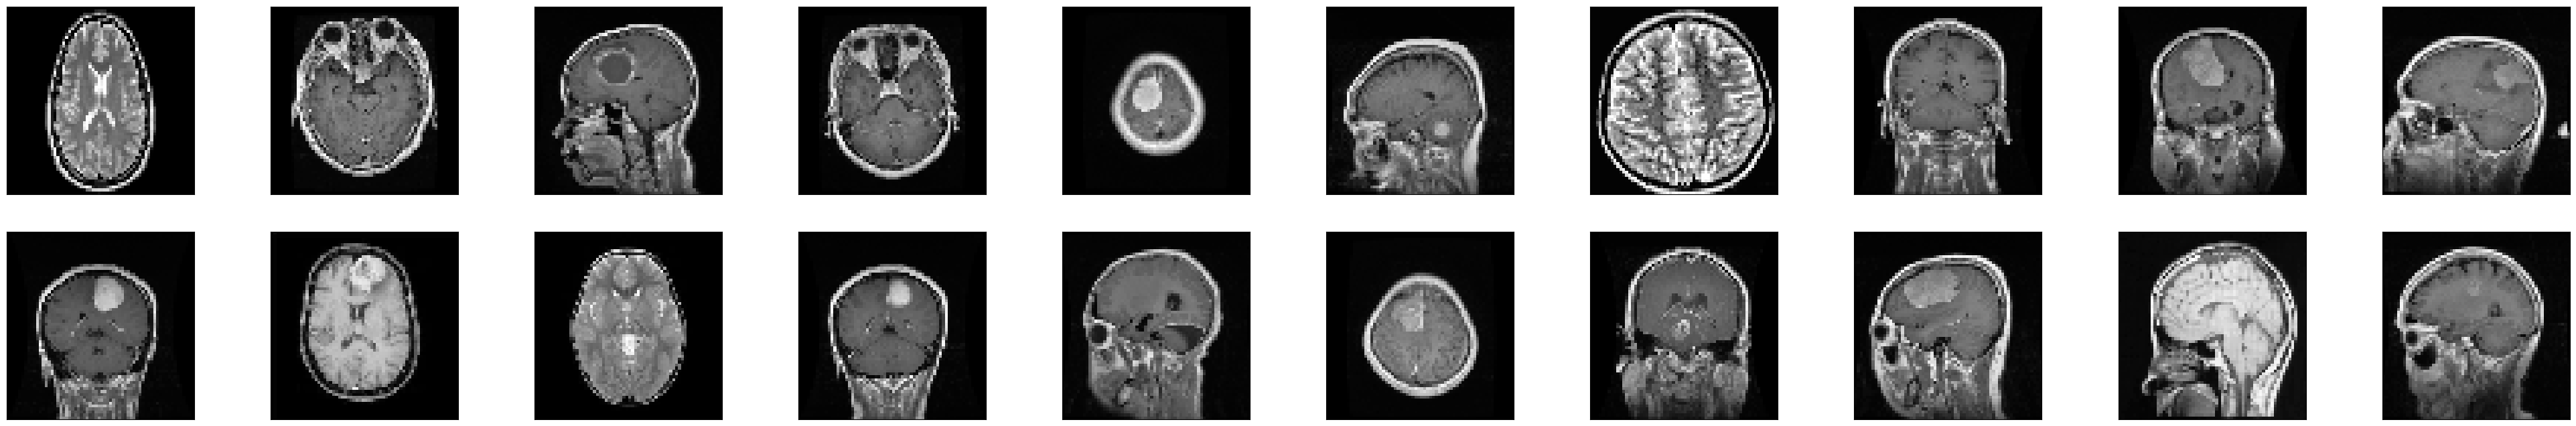

In [61]:
plot_images(svc.support_vectors_.reshape((-1, img_size, img_size)), nrow=2, ncol=10)

By the plot, svm is using some representative positional features, especially for meningioma and pituitary tumor type, to determine where the boundary should lie.

Cross-validation is used to evaluate the performance on train set, and we can see scores on real world test set as well.

In [62]:
cv_score = cross_validate(estimator=svc, X=x_train, y=y_train,scoring=['accuracy', 'f1_macro'], cv=8)

In [63]:
print(f"Cross-validate accuracy (mean): {np.mean(cv_score['test_accuracy'])}")
print(f"Cross-validate accuracy (std): {np.std(cv_score['test_accuracy'])}")
print(f"Cross-validate f1-score (mean): {np.mean(cv_score['test_f1_macro'])}")
print(f"Cross-validate f1-score (std): {np.std(cv_score['test_f1_macro'])}")

Cross-validate accuracy (mean): 0.8197983613700378
Cross-validate accuracy (std): 0.014731632550391227
Cross-validate f1-score (mean): 0.8115595717913774
Cross-validate f1-score (std): 0.017265783179461345


SVM classification have stable performance of score on train set. Taking into account the difference in nature between train and test set, this performance on test set is completely accceptable for us.

### Logistic Regression
As a generalized linear regression model, logistic regressiom also applies to multi-label classification task.

In [64]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter=10000,)
lr_model.fit(x_train, y_train)

LogisticRegression(max_iter=10000)

Similarly, cross-validation is used to evaluate the performance on train set, and performance on real-world test data is also revealed.

In [65]:
cv_score = cross_validate(estimator=lr_model, X=x_train, y=y_train,scoring=['accuracy', 'f1_macro'], cv=8)
print(f"Cross-validate accuracy (mean): {np.mean(cv_score['test_accuracy'])}")
print(f"Cross-validate accuracy (std): {np.std(cv_score['test_accuracy'])}")
print(f"Cross-validate f1-score (mean): {np.mean(cv_score['test_f1_macro'])}")
print(f"Cross-validate f1-score (std): {np.std(cv_score['test_f1_macro'])}")

Cross-validate accuracy (mean): 0.8096814164111981
Cross-validate accuracy (std): 0.023047148992592102
Cross-validate f1-score (mean): 0.797747738447371
Cross-validate f1-score (std): 0.02801275076448307


Overall performance is slightly lower than SVM model, but it is still rewarding, since it gains higher accuracy than baseline model in each class in comparison with dummy classifier. For this task, we will choose SVM for later comparison. Now check its performance on the test set.

In [66]:
y_test_pred = svc.predict(x_test)
print(classification_report(y_pred=y_test_pred, y_true=y_test))

                  precision    recall  f1-score   support

    glioma_tumor       0.53      0.17      0.26       100
meningioma_tumor       0.69      0.90      0.78       115
        no_tumor       0.57      0.89      0.69       105
 pituitary_tumor       0.79      0.51      0.62        74

        accuracy                           0.64       394
       macro avg       0.65      0.62      0.59       394
    weighted avg       0.64      0.64      0.60       394



Moreover, given the good performance of SVM, we also want to see where the model has made mistakes.

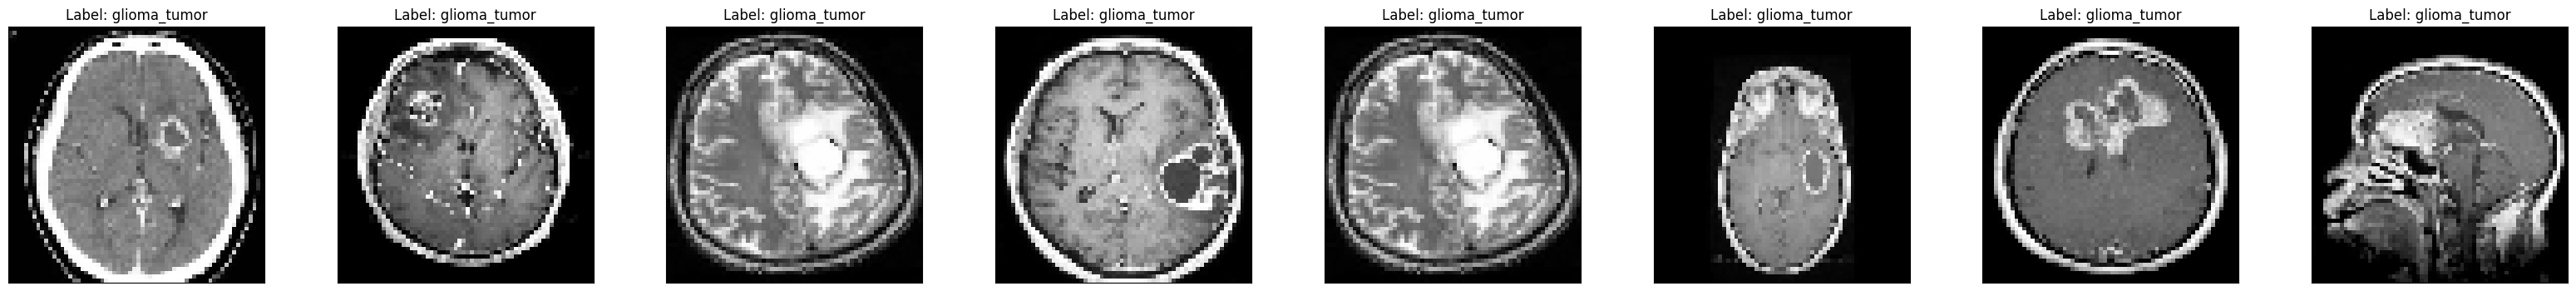

In [67]:
y_test_pred = svc.predict(x_test)
label = "glioma_tumor"
misclassified_samples = x_test[(y_test_pred == "no_tumor") & (y_test == label)]
misclassified_labels = y_test[(y_test_pred == "no_tumor") & (y_test == label)]
plot_images(misclassified_samples.reshape((-1,64,64)), misclassified_labels, nrow=1, ncol=8, randomize=False)

From the plot, we can say that prediction for most misclassified samples fails for its small, multivocal or complex shape, this actually shows an underlying underfitting feature of classical methods such as SVM. In this way, convolutional neural network is required to capture more detailed feature for classification.

### Convolutional Neural Network
Convolutional deep network is built for this task. Since cross-validation is too expensive in this case, a standard 7-2-1 train-validation-test split is carried out.

In [68]:
img_size = 128
(x_train, x_validate, x_test,
 y_train, y_validate, y_test) = import_images(labels, img_size, 0.2)
image_shape = (img_size, img_size, 3)

100%|██████████| 105/105 [00:00<00:00, 780.72it/s]


In [69]:
from keras.layers import Input, Dense, Conv2D, MaxPool2D, ReLU, Flatten, Dropout
from keras.models import Model
def convolutional_model(input_shape=image_shape):
    input_img = Input(shape=input_shape)
    x = Conv2D(filters=128, kernel_size=(4, 4), padding="same")(input_img)
    x = ReLU()(x)
    x = MaxPool2D(pool_size=(4, 4), strides=4, padding="same")(x)
    
    x = Conv2D(filters=128, kernel_size=(2, 2), padding="same")(x)
    x = ReLU()(x)
    x = MaxPool2D(pool_size=(4, 4), strides=4, padding="same")(x)
    
    x = Conv2D(filters=64, kernel_size=(2, 2), padding="same")(x)
    x = ReLU()(x)
    x = MaxPool2D(pool_size=(4, 4), strides=4, padding="same")(x)
    x = Dropout(0.2)(x)
    
    x = Flatten()(x)
    x = Dense(units=32, activation="relu")(x)
    outputs = Dense(units=4, activation="softmax")(x)
    model = Model(inputs=input_img, outputs=outputs)
    return model

In [70]:
conv_model = convolutional_model(image_shape)
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 128)     6272      
                                                                 
 re_lu_3 (ReLU)              (None, 128, 128, 128)     0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 128)       65664     
                                                                 
 re_lu_4 (ReLU)              (None, 32, 32, 128)       0         
                                                           

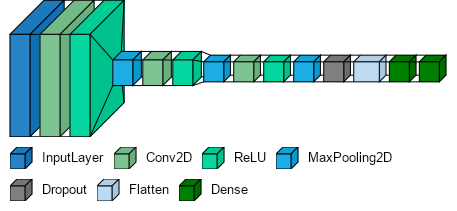

In [71]:
plot_nn_structure(conv_model)

By the design above, this is a very standard convolutional network sequential structure, ending with dense layers. A dropout layer is included to avoid overfitting.

In [72]:
# history = conv_model.fit(x=x_train, y=y_train,
#                epochs=25,
#                validation_data=(x_validate, y_validate),
#                verbose=1)

# import json
# # save the model
# conv_model.save(os.path.join(".","saved_model","conv_model.keras"))

# history.history["epoch"] = history.epoch
# with open(os.path.join(".", "saved_model", "conv_model_training_history.json"), "w") as json_file:
#     json.dump(history.history, json_file)

# history = history.history

In [75]:
# load the model
import json, os
from keras.models import load_model
conv_model = load_model(os.path.join("saved_model", "conv_model.keras"))
with open(os.path.join("saved_model", "conv_model_training_history.json"), "r") as json_file:
    history = json.load(json_file)


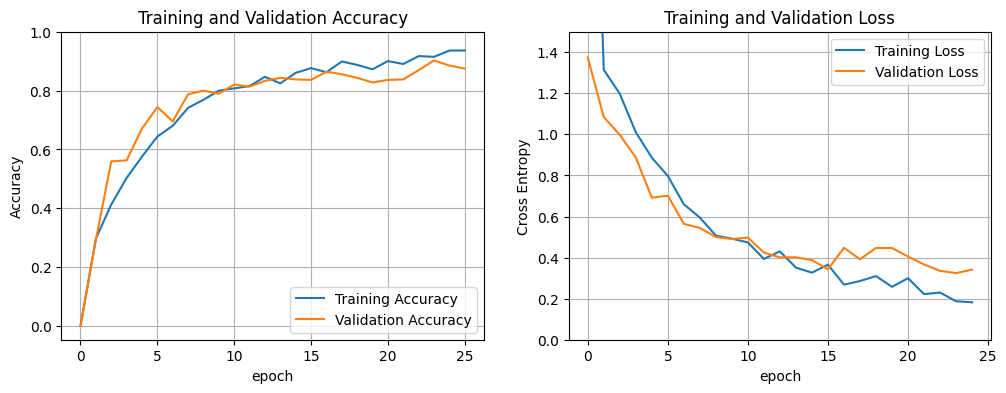

In [76]:
from matplotlib import pyplot as plt
acc = [0.] + history['accuracy']
val_acc = [0.] + history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid(True)
plt.show()

By the accuracy and loss curve, training process is smooth and did not show sign of overfitting.

Next we directly use metrics on validation set and test set for evaluation.

In [77]:
y_validate_pred = conv_model.predict(x_validate)
y_validate_pred = [labels[_] for _ in np.argmax(y_validate_pred, axis=1)]
y_validate_new = [labels[_] for _ in np.argmax(y_validate, axis=1)]
print(classification_report(y_pred=y_validate_pred, y_true=y_validate_new))

 1/18 [>.............................] - ETA: 2s

18/18 [==============================] - 2s 98ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.99      0.98       180
meningioma_tumor       0.95      0.93      0.94       138
        no_tumor       0.92      0.99      0.95        83
 pituitary_tumor       1.00      0.97      0.98       173

        accuracy                           0.97       574
       macro avg       0.96      0.97      0.96       574
    weighted avg       0.97      0.97      0.97       574



In [78]:
y_test_pred = conv_model.predict(x_test)
y_test_pred = [labels[_] for _ in np.argmax(y_test_pred, axis=1)]
y_test_new = [labels[_] for _ in np.argmax(y_test, axis=1)]
print(classification_report(y_pred=y_test_pred, y_true=y_test_new))

 1/13 [=>............................] - ETA: 1s

13/13 [==============================] - 1s 95ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.77      0.20      0.32       100
meningioma_tumor       0.64      0.57      0.60       115
        no_tumor       0.46      1.00      0.63       105
 pituitary_tumor       0.84      0.43      0.57        74

        accuracy                           0.56       394
       macro avg       0.68      0.55      0.53       394
    weighted avg       0.66      0.56      0.53       394



The results show that though f1-score on validation set improves, test set performance is not ideal, indicating underlying overfitting issue. This inspires us to do data augmentation and more dropouts for better performance later.

### Transfer Learning: MobileNet V2

In computer vison aspects, it is known that a high-performance model for one task has good chances to work fine on another. And some researchers have put trained network like VGG16 on previous brain tumor detection tasks and get satisfactory results. However, training and tuning of VGG16 still cost a lot for the device, so this project tests MobileNet V2 for its low computational cost.

#### Inroduction to MobileNet V2

The MobileNetV2 architecture can be viewed as a special case of residue network, composed of various convolutional block, and, in MobileNet V2, the input and output of the block are thin bottleneck layers, a light-weight representation in comparison to traditional ones. More importantly, MobileNetV2 uses depthwise-separable convolutions in the intermediate layer, which save much computational costs. This network was originally targeted at network implementations on mobile devices.

#### Data Augumentation

First, build a specific augmentation layer for MRI images. This augmenter introduces random flipping for symmetries, random zoom and random contrast for positional features and random width to counter the stretch of images caused by reshaping.

In [79]:
from keras.layers import RandomFlip, RandomZoom, RandomContrast, RandomWidth
from keras import Sequential
def data_augmenter(flp=False, zm=False, ctt=True, wd=True):
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''

    data_augmentation = Sequential()
    if flp:
        data_augmentation.add(RandomFlip('horizontal'))
    if zm:
        data_augmentation.add(RandomZoom(0.2, fill_mode="constant"))
    if ctt:
        data_augmentation.add(RandomContrast(0.2))
    if wd:
        data_augmentation.add(RandomWidth(0.1))
    
    return data_augmentation

Preview the effect of our augmenter

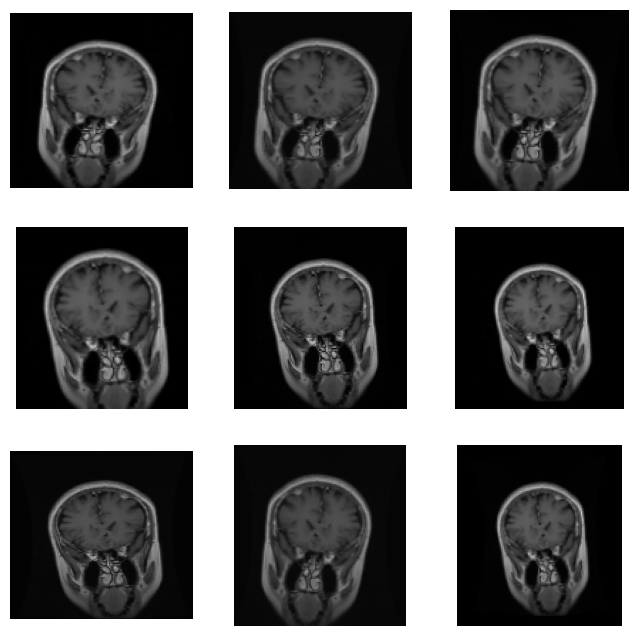

In [80]:
import tensorflow as tf
data_augmentation = data_augmenter(flp=True, zm=True, ctt=True, wd=True)
image = x_train
plt.figure(figsize=(8, 8))
first_image = image[3]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

By the visualization, we can see that a single image is randomly mapped to different copies, and some of them indeed matches the patterns of occurence in our real-world MRI data.

In order to fit the pretrained network in our task, the top layers need to be modified. And we use pretrained weights from ImageNet.

In [81]:
from keras.layers import Input, Dropout, GlobalAveragePooling2D, Dense
from keras.models import Model

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
img_shape = (img_size, img_size, 3)

def tumor_model(img_shape=img_shape, data_augmentation=data_augmenter()):
    input_shape = img_shape
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
    base_model.trainable = False
    inputs = Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    # x = Dropout(0.3)(x)
    # x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(4, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

In [82]:
model = tumor_model(img_shape)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 128, None, 3)      0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 128, None, 3)      0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 128, None, 3)      0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                           

From the structure, only top layers are trainable in this case. Base learning rate is set to 0.001 for test

In [83]:
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
base_learning_rate = 0.001
model.compile(optimizer=Adam(base_learning_rate),
              loss=categorical_crossentropy,
              metrics=['accuracy'])

In [84]:
initial_epochs = 5
history = model.fit(x=x_train, y=y_train, 
                    validation_data=(x_validate, y_validate), 
                    epochs=initial_epochs,
                    verbose=1)

Epoch 1/5


72/72 [==============================] - 21s 239ms/step - loss: 1.0068 - accuracy: 0.5854 - val_loss: 0.5827 - val_accuracy: 0.7770
Epoch 2/5
72/72 [==============================] - 15s 214ms/step - loss: 0.5887 - accuracy: 0.7683 - val_loss: 0.4702 - val_accuracy: 0.8328
Epoch 3/5
72/72 [==============================] - 15s 212ms/step - loss: 0.5102 - accuracy: 0.8114 - val_loss: 0.4197 - val_accuracy: 0.8397
Epoch 4/5
72/72 [==============================] - 15s 209ms/step - loss: 0.4539 - accuracy: 0.8262 - val_loss: 0.3731 - val_accuracy: 0.8571
Epoch 5/5
72/72 [==============================] - 16s 217ms/step - loss: 0.4023 - accuracy: 0.8484 - val_loss: 0.3769 - val_accuracy: 0.8519


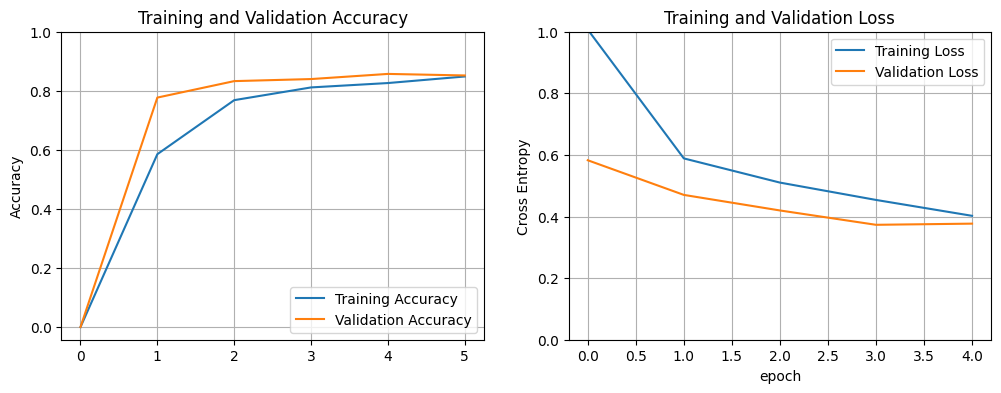

In [85]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid(True)
plt.show()

First 5 epoches have achieved good performance, and we start fine tune for more progress.

In [86]:
base_model = model.layers[4]
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 140

for layers in base_model.layers[:fine_tune_at]:
    layers.trainable = False
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(0.08*base_learning_rate),
              metrics=['accuracy'])

Number of layers in the base model:  154


In [87]:
from keras.callbacks import EarlyStopping

fine_tune_epochs = 15
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(x=x_train, y=y_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(x_validate, y_validate),
                         verbose=1,
                         callbacks=[EarlyStopping("val_loss", patience=5, restore_best_weights=True)])

Epoch 5/20


72/72 [==============================] - 23s 266ms/step - loss: 0.4343 - accuracy: 0.8323 - val_loss: 0.3236 - val_accuracy: 0.8711
Epoch 6/20
72/72 [==============================] - 18s 247ms/step - loss: 0.3106 - accuracy: 0.8767 - val_loss: 0.5977 - val_accuracy: 0.7997
Epoch 7/20
72/72 [==============================] - 18s 245ms/step - loss: 0.2651 - accuracy: 0.8994 - val_loss: 0.3238 - val_accuracy: 0.8885
Epoch 8/20
72/72 [==============================] - 17s 243ms/step - loss: 0.2269 - accuracy: 0.9151 - val_loss: 0.2549 - val_accuracy: 0.9146
Epoch 9/20
72/72 [==============================] - 17s 239ms/step - loss: 0.1793 - accuracy: 0.9290 - val_loss: 0.3223 - val_accuracy: 0.8815
Epoch 10/20
72/72 [==============================] - 17s 239ms/step - loss: 0.1742 - accuracy: 0.9290 - val_loss: 0.2915 - val_accuracy: 0.8937
Epoch 11/20
72/72 [==============================] - 18s 251ms/step - loss: 0.1720 - accuracy: 0.9351 - val_loss: 0.2676 - val_accuracy: 0.9111
Epoch 12

In [88]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

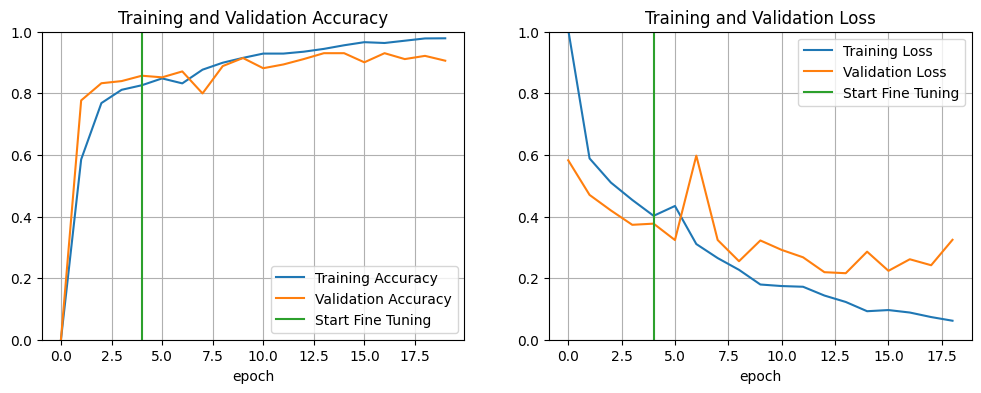

In [89]:
import numpy as np
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid(True)
plt.show()

By the plot, accuracy and loss have apparent improvement after fine-tuning epoches.

Then detailed evaluation is conducted through f1-score metrics for each prediction class.

In [90]:
from sklearn.metrics import classification_report, confusion_matrix
y_validate_pred = model.predict(x_validate)
y_validate_pred = [labels[_] for _ in np.argmax(y_validate_pred, axis=1)]
y_validate_new = [labels[_] for _ in np.argmax(y_validate, axis=1)]
print(classification_report(y_pred=y_validate_pred, y_true=y_validate_new))

18/18 [==============================] - 4s 180ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.91      0.93       180
meningioma_tumor       0.87      0.91      0.89       138
        no_tumor       0.94      0.93      0.93        83
 pituitary_tumor       0.95      0.97      0.96       173

        accuracy                           0.93       574
       macro avg       0.93      0.93      0.93       574
    weighted avg       0.93      0.93      0.93       574



In [91]:
from sklearn.metrics import classification_report, confusion_matrix
y_test_pred = model.predict(x_test)
y_test_pred = [labels[_] for _ in np.argmax(y_test_pred, axis=1)]
y_test_new = [labels[_] for _ in np.argmax(y_test, axis=1)]
print(classification_report(y_pred=y_test_pred, y_true=y_test_new))

13/13 [==============================] - 2s 176ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.21      0.34       100
meningioma_tumor       0.64      0.93      0.76       115
        no_tumor       0.72      0.98      0.83       105
 pituitary_tumor       0.90      0.73      0.81        74

        accuracy                           0.72       394
       macro avg       0.80      0.71      0.68       394
    weighted avg       0.79      0.72      0.68       394



The most fundamental improvements come with test set, we can clearly see the new model with data augmentation performs the best on real-world data.

#### Model Comparison
From train, validate, and test performance using both F1-score, accuracy as metrics, we can see that Transfer Learning methods have the best performance over all, with acceptable training time. Moreover, for the cost of model fitting, SVM is an efficient way of classification as well.

Now confusion matrix is plotted to reveal more details.

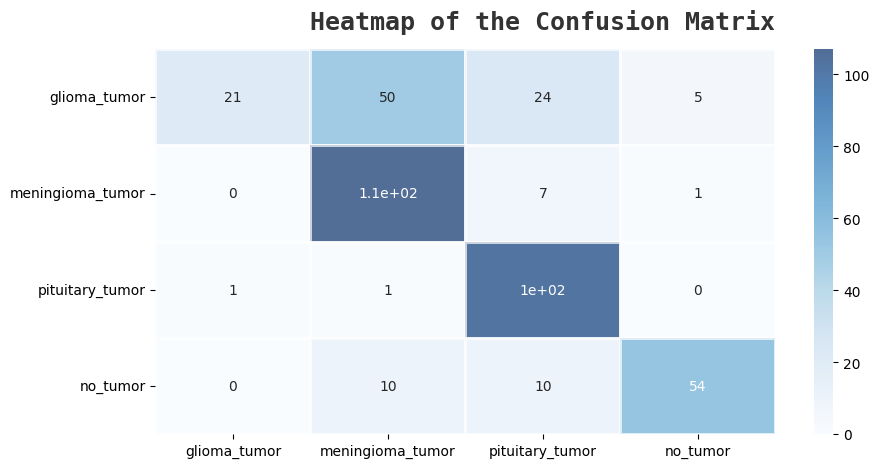

In [92]:
import seaborn as sns
fig,ax=plt.subplots(1,1,figsize=(10,5))
sns.heatmap(confusion_matrix(y_test_new, y_test_pred),
            ax=ax,
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            alpha=0.7,
            linewidths=2,
            cmap='Blues')
fig.text(s='Heatmap of the Confusion Matrix',
         size=18,fontweight='bold',
         fontname='monospace',
         y=0.92,
         x=0.28,
         alpha=0.8)

plt.show()

The confusion matrix for test set tells that the best combined model correctly predicts pituitary tumor type, meningioma tumor type and those without tumor, and have some uncertainty over glioma tumor type. We can plot some misclassified samples for closer examination.

#### Misclassified Samples
Now we do simple operations to identify where the model has made mistakes.

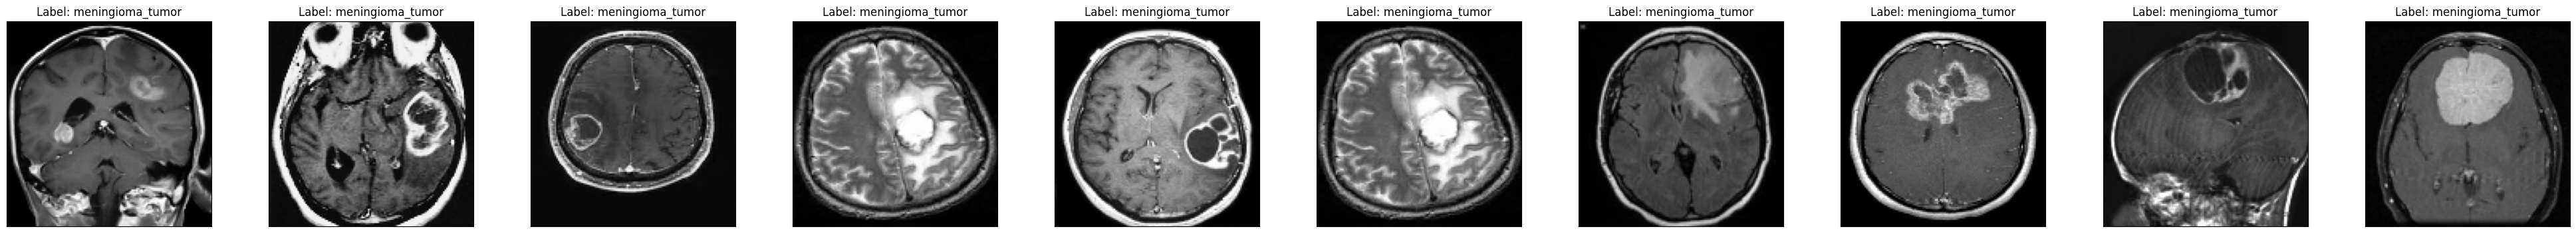

In [93]:
y_test_new = np.array(y_test_new)
y_test_pred = np.array(y_test_pred)
label = "glioma_tumor"
label1 = "no_tumor"
misclassified_samples = x_test[(y_test_pred == "meningioma_tumor") & (y_test_new == label)]
misclassified_labels = y_test_pred[(y_test_pred == "meningioma_tumor") & (y_test_new == label)]
plot_images(misclassified_samples, misclassified_labels, nrow=1, ncol=10, randomize=False)


According to the misclassified patterns, for those samples of glioma tumor misclassified as meningioma tumor, most of them are small or very close to the brain surface (according to the typical medical distinction of meningioma tumor). And for samples of glioma tumor misclassified as pituitary tumor, about 4 of them are just copy of similar MRI scans, and others are with poor ratio and contrast. 

Actually, it is not suprising that glioma tumor type have low predicting results. While other 2 tumor types have distinctive origins or exact positions in the brain, glioma tumor **can be inferred only from the shape and texture**, because they are defined to originate from a certain type of cell that is ubiquitus in the brain. 

Positional features are just what convolutional-based network good at, but texture and shape information are largely subject to the source images. In this way, the predicting results of glioma tumor type suffer most from **noisy points, distorted images, and low resolutions** in the test set provided. This may explain the reason behind the abnormal predicting result for glioma tumor. Actually, in current industrial application of medical vision, the training and detection still strongly requires the supervision and justification of professional doctors.

Conclusively, in terms of this task, given the quality of our test set, our best model has reasonable and good performance results.